
# Importamos Librerias

In [23]:
# imports time series
import pandas as pd
import numpy as np

# plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
from random import random

# Preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Evaluacion
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.metrics import mean_squared_error

# misc
import os
import time
import itertools
import warnings
warnings.filterwarnings("ignore")

# apartado ts
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA

#Otros Modelos

# Modelos ML de Regresion

import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBRegressor

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

from prophet import Prophet

import pickle
import os

from datetime import datetime

from sklearn.model_selection import RandomizedSearchCV


#Tamño default de los plots
plt.rcParams["figure.figsize"] = [10,6]



# Importamos DATASET

In [24]:
# Leemos los ficheros
DATA_PATH = 'C:/Users/mpgir/Desktop/Data Science/Capstone/DS-Capstone-Market/data/'
df_forecast= pd.read_csv(DATA_PATH+'weekly_sales_cleandata.csv')

In [25]:
# Leemos los ficheros
DATA_PATH = 'C:/Users/mpgir/Desktop/Data Science/Capstone/DS-Capstone-Market/data/'
df_events= pd.read_csv(DATA_PATH+'daily_calendar_with_events.csv')

In [26]:
df_events.info() #Miramos el df_events

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1913 entries, 0 to 1912
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         1913 non-null   object
 1   weekday      1913 non-null   object
 2   weekday_int  1913 non-null   int64 
 3   d            1913 non-null   object
 4   event        26 non-null     object
dtypes: int64(1), object(4)
memory usage: 74.9+ KB


In [27]:
#Agrupamos por "yearweek", para despues cruzar con el otro df
df_events['date'] = pd.to_datetime(df_events['date'])
df_events['yearweek'] = df_events['date'].dt.strftime('%Y%U').astype(int)

In [28]:
df_events.head()

,date,weekday,weekday_int,d,event,yearweek
0,2011-01-29,Saturday,1,d_1,NaN,201104
1,2011-01-30,Sunday,2,d_2,NaN,201105
2,2011-01-31,Monday,3,d_3,NaN,201105
3,2011-02-01,Tuesday,4,d_4,NaN,201105
4,2011-02-02,Wednesday,5,d_5,NaN,201105


In [29]:
df_events.fillna(0, inplace=True) #Llenamos los NA para que cuando hagamos el merge, salga bien
df_events.isnull().sum()

date           0
weekday        0
weekday_int    0
d              0
event          0
yearweek       0
dtype: int64

In [30]:
#convertimos a String y agrupamos porque ambos df tienen distinta granularidad
df_events= df_events.groupby('yearweek')['event'].apply(lambda x: ','.join(x.astype(str))).reset_index() 

In [31]:
#Hacemos el "left" para no aumentar filas, pero si una columna
print(df_forecast.shape) 

df = pd.merge(df_forecast, df_events[['yearweek', 'event']], on='yearweek', how='left')

print(df.shape)

(8354260, 10)


(8354260, 11)


In [32]:
#Limpiamos despues del join
df['event'] = df['event'].str.replace('0,', '').str.replace(',0', '')

In [33]:
df[df["event"].isnull()] #Miramos la semana 201553, que no tenemos registros de eventos

,id,item,category,department,store,store_code,region,yearweek,qty_sold,sell_price,event
257,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,201553,4,10.9858,NaN
531,ACCESORIES_1_001_BOS_2,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Roxbury,BOS_2,Boston,201553,5,10.9858,NaN
805,ACCESORIES_1_001_BOS_3,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Back_Bay,BOS_3,Boston,201553,9,10.9858,NaN
1079,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,201553,6,10.9858,NaN
1353,ACCESORIES_1_001_NYC_2,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Harlem,NYC_2,New York,201553,0,10.9858,NaN
...,...,...,...,...,...,...,...,...,...,...,...
8353147,SUPERMARKET_3_827_NYC_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Tribeca,NYC_3,New York,201553,41,1.2000,NaN
8353421,SUPERMARKET_3_827_NYC_4,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Brooklyn,NYC_4,New York,201553,0,1.2000,NaN
8353695,SUPERMARKET_3_827_PHI_1,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Midtown_Village,PHI_1,Philadelphia,201553,26,1.2000,NaN
8353969,SUPERMARKET_3_827_PHI_2,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Yorktown,PHI_2,Philadelphia,201553,11,1.2000,NaN


In [34]:
df["event"].fillna("0", inplace=True) #Llenamos los NA de la semana 201553
df.isnull().sum()

id            0
item          0
category      0
department    0
store         0
store_code    0
region        0
yearweek      0
qty_sold      0
sell_price    0
event         0
dtype: int64

In [35]:
df["event"].value_counts()

event
0                 7683480
SuperBowl          182940
Ramadan starts     152450
Thanksgiving       152450
Easter             152450
NewYear             30490
Name: count, dtype: int64

In [36]:
df_forecast=df.copy()

In [37]:
#Miramos cuantas filas y columnas tiene el df Weekly_sales_clean_data
df_forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8354260 entries, 0 to 8354259
Data columns (total 11 columns):
 #   Column      Dtype  
---  ------      -----  
 0   id          object 
 1   item        object 
 2   category    object 
 3   department  object 
 4   store       object 
 5   store_code  object 
 6   region      object 
 7   yearweek    int64  
 8   qty_sold    int64  
 9   sell_price  float64
 10  event       object 
dtypes: float64(1), int64(2), object(8)
memory usage: 701.1+ MB


In [38]:
df_forecast.head()

,id,item,category,department,store,store_code,region,yearweek,qty_sold,sell_price,event
0,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,201104,0,12.7414,0
1,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,201105,0,12.7414,0
2,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,201106,0,12.7414,SuperBowl
3,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,201107,0,12.7414,0
4,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,201108,0,12.7414,0


In [39]:
# 3.363.362 rows × 10 columns registros con venta cero, que son el 40% del total de registros.
venta_cero=df_forecast [df_forecast['qty_sold']<=0]

In [40]:
venta_cero["id"].value_counts() #vemos que no es un producto en especial, sino varios.

id
HOME_&_GARDEN_1_020_NYC_3    270
HOME_&_GARDEN_1_400_NYC_4    270
HOME_&_GARDEN_1_032_BOS_1    269
SUPERMARKET_3_778_NYC_2      269
SUPERMARKET_3_135_PHI_2      269
                            ... 
SUPERMARKET_3_534_PHI_3        1
ACCESORIES_1_319_PHI_1         1
SUPERMARKET_3_109_NYC_3        1
SUPERMARKET_3_107_NYC_3        1
HOME_&_GARDEN_1_243_PHI_2      1
Name: count, Length: 30131, dtype: int64

In [41]:
venta_cero["yearweek"].value_counts() #también son varias semanas y años.

yearweek
201104    21742
201105    19543
201107    19404
201108    19358
201109    19307
          ...  
201612     5730
201613     5341
201615     5244
201614     5039
201616     4890
Name: count, Length: 274, dtype: int64

In [42]:
#Creamos columnas Year y Week para  analizar después
df_forecast['year'] = df_forecast['yearweek'] // 100 
df_forecast['week'] = df_forecast['yearweek'] % 100 


In [43]:
#Convertimos Columna "yearweek"a formato datetime.
#Primero convertimos todo a objeto para despues aplicar datetime

df_forecast[['yearweek', 'year', 'week']] = df_forecast[['yearweek', 'year', 'week']].apply(lambda x: x.astype(str))

#aplicamos un "0" para que tenga formato Día y se pueda aplica el formato datetime
df_forecast['yearweek'] = df_forecast['yearweek'] + '0'
df_forecast['yearweek'] = pd.to_datetime(df_forecast['yearweek'], format='%Y%W%w')


In [44]:
df_forecast.head()

,id,item,category,department,store,store_code,region,yearweek,qty_sold,sell_price,event,year,week
0,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-01-30,0,12.7414,0,2011,4
1,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-06,0,12.7414,0,2011,5
2,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-13,0,12.7414,SuperBowl,2011,6
3,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-20,0,12.7414,0,2011,7
4,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-27,0,12.7414,0,2011,8


In [45]:
df_forecast[['year', 'week']] = df_forecast[['year', 'week']].apply(pd.to_numeric)


In [46]:
#Tenemos 30.490 series temporales
df_forecast["id"].nunique()

30490

In [47]:
MIN_DATE = df_forecast["yearweek"].min()
MAX_DATE = df_forecast["yearweek"].max()

In [48]:
print(f"Min date is {MIN_DATE}\nMax date is {MAX_DATE}") 

Min date is 2011-01-30 00:00:00
Max date is 2016-04-24 00:00:00


In [49]:
df_forecast.isnull().sum() #No tenemos nulos porque anteriormente los imputamos con el bfil y ffill en notebook dataclean

id            0
item          0
category      0
department    0
store         0
store_code    0
region        0
yearweek      0
qty_sold      0
sell_price    0
event         0
year          0
week          0
dtype: int64


# Data Imputation


In [50]:
sample_ts = "HOME_&_GARDEN_1_020_NYC_3" # selecionamos una serie temporal, para analizar despues

In [51]:
df_forecast[df_forecast["id"] == sample_ts]

,id,item,category,department,store,store_code,region,yearweek,qty_sold,sell_price,event,year,week
1601530,HOME_&_GARDEN_1_020_NYC_3,HOME_&_GARDEN_1_020,HOME_&_GARDEN,HOME_&_GARDEN_1,Tribeca,NYC_3,New York,2011-01-30,0,8.7125,0,2011,4
1601531,HOME_&_GARDEN_1_020_NYC_3,HOME_&_GARDEN_1_020,HOME_&_GARDEN,HOME_&_GARDEN_1,Tribeca,NYC_3,New York,2011-02-06,0,8.7125,0,2011,5
1601532,HOME_&_GARDEN_1_020_NYC_3,HOME_&_GARDEN_1_020,HOME_&_GARDEN,HOME_&_GARDEN_1,Tribeca,NYC_3,New York,2011-02-13,0,8.7125,SuperBowl,2011,6
1601533,HOME_&_GARDEN_1_020_NYC_3,HOME_&_GARDEN_1_020,HOME_&_GARDEN,HOME_&_GARDEN_1,Tribeca,NYC_3,New York,2011-02-20,0,8.7125,0,2011,7
1601534,HOME_&_GARDEN_1_020_NYC_3,HOME_&_GARDEN_1_020,HOME_&_GARDEN,HOME_&_GARDEN_1,Tribeca,NYC_3,New York,2011-02-27,0,8.7125,0,2011,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1601799,HOME_&_GARDEN_1_020_NYC_3,HOME_&_GARDEN_1_020,HOME_&_GARDEN,HOME_&_GARDEN_1,Tribeca,NYC_3,New York,2016-03-27,2,8.7125,0,2016,12
1601800,HOME_&_GARDEN_1_020_NYC_3,HOME_&_GARDEN_1_020,HOME_&_GARDEN,HOME_&_GARDEN_1,Tribeca,NYC_3,New York,2016-04-03,6,8.7125,Easter,2016,13
1601801,HOME_&_GARDEN_1_020_NYC_3,HOME_&_GARDEN_1_020,HOME_&_GARDEN,HOME_&_GARDEN_1,Tribeca,NYC_3,New York,2016-04-10,0,8.7125,0,2016,14
1601802,HOME_&_GARDEN_1_020_NYC_3,HOME_&_GARDEN_1_020,HOME_&_GARDEN,HOME_&_GARDEN_1,Tribeca,NYC_3,New York,2016-04-17,0,8.7125,0,2016,15


In [52]:
# Ordenar el DataFrame por las columnas "id" y "yearweek"
df_forecast.sort_values(["id", "yearweek"], ascending=True, inplace=True)

In [53]:
df_forecast.head()

,id,item,category,department,store,store_code,region,yearweek,qty_sold,sell_price,event,year,week
0,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-01-30,0,12.7414,0,2011,4
1,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-06,0,12.7414,0,2011,5
2,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-13,0,12.7414,SuperBowl,2011,6
3,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-20,0,12.7414,0,2011,7
4,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-27,0,12.7414,0,2011,8


In [54]:
df_forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8354260 entries, 0 to 8354259
Data columns (total 13 columns):
 #   Column      Dtype         
---  ------      -----         
 0   id          object        
 1   item        object        
 2   category    object        
 3   department  object        
 4   store       object        
 5   store_code  object        
 6   region      object        
 7   yearweek    datetime64[ns]
 8   qty_sold    int64         
 9   sell_price  float64       
 10  event       object        
 11  year        int64         
 12  week        int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(8)
memory usage: 828.6+ MB


In [55]:
yearweek_column = df_forecast.pop('yearweek')
id_column = df_forecast.pop('id')
df_forecast.insert(0, 'yearweek', yearweek_column)
df_forecast.insert(1, 'id', id_column)

In [56]:
df_forecast[df_forecast["id"] == sample_ts]

,yearweek,id,item,category,department,store,store_code,region,qty_sold,sell_price,event,year,week
1601530,2011-01-30,HOME_&_GARDEN_1_020_NYC_3,HOME_&_GARDEN_1_020,HOME_&_GARDEN,HOME_&_GARDEN_1,Tribeca,NYC_3,New York,0,8.7125,0,2011,4
1601531,2011-02-06,HOME_&_GARDEN_1_020_NYC_3,HOME_&_GARDEN_1_020,HOME_&_GARDEN,HOME_&_GARDEN_1,Tribeca,NYC_3,New York,0,8.7125,0,2011,5
1601532,2011-02-13,HOME_&_GARDEN_1_020_NYC_3,HOME_&_GARDEN_1_020,HOME_&_GARDEN,HOME_&_GARDEN_1,Tribeca,NYC_3,New York,0,8.7125,SuperBowl,2011,6
1601533,2011-02-20,HOME_&_GARDEN_1_020_NYC_3,HOME_&_GARDEN_1_020,HOME_&_GARDEN,HOME_&_GARDEN_1,Tribeca,NYC_3,New York,0,8.7125,0,2011,7
1601534,2011-02-27,HOME_&_GARDEN_1_020_NYC_3,HOME_&_GARDEN_1_020,HOME_&_GARDEN,HOME_&_GARDEN_1,Tribeca,NYC_3,New York,0,8.7125,0,2011,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1601799,2016-03-27,HOME_&_GARDEN_1_020_NYC_3,HOME_&_GARDEN_1_020,HOME_&_GARDEN,HOME_&_GARDEN_1,Tribeca,NYC_3,New York,2,8.7125,0,2016,12
1601800,2016-04-03,HOME_&_GARDEN_1_020_NYC_3,HOME_&_GARDEN_1_020,HOME_&_GARDEN,HOME_&_GARDEN_1,Tribeca,NYC_3,New York,6,8.7125,Easter,2016,13
1601801,2016-04-10,HOME_&_GARDEN_1_020_NYC_3,HOME_&_GARDEN_1_020,HOME_&_GARDEN,HOME_&_GARDEN_1,Tribeca,NYC_3,New York,0,8.7125,0,2016,14
1601802,2016-04-17,HOME_&_GARDEN_1_020_NYC_3,HOME_&_GARDEN_1_020,HOME_&_GARDEN,HOME_&_GARDEN_1,Tribeca,NYC_3,New York,0,8.7125,0,2016,15


# EDA

### --> 1. EDA: Global Sales

In [57]:
def plot_ts_acf_pacf(y, title):
    '''
    Plots the ts you pass and the acf and pacf.
    '''
    fig = plt.figure(figsize = (12, 10))
    ax1, ax2, ax3 = fig.subplots(3, 1)

    ax1.plot(y)
    plot_acf(x = y, ax = ax2, lags = 14)
    plot_pacf(x = y, ax = ax3, lags = 14)

    plt.suptitle(t = title, fontsize = 20)
    

In [58]:
y = df_forecast.groupby("yearweek")["qty_sold"].sum()

In [59]:
y = y.iloc[:-4]

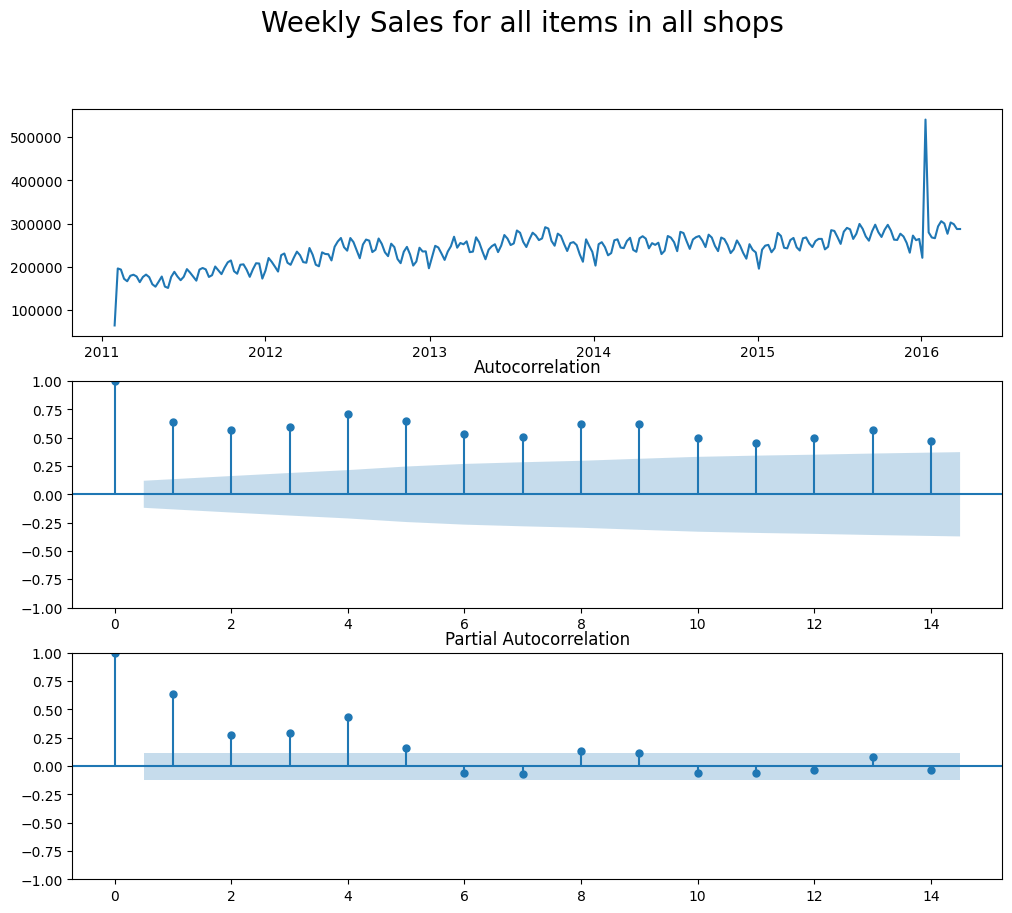

In [60]:
plot_ts_acf_pacf(y = y, title = "Weekly Sales for all items in all shops");

Analizamos los peaks en ventas del 2016. probablemente Reyes!!

<Axes: xlabel='yearweek'>

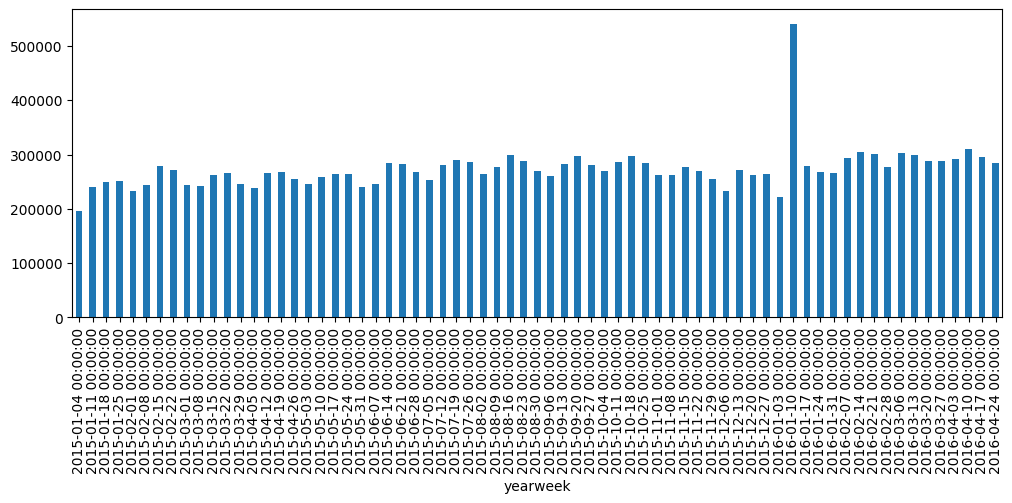

In [61]:
(df_forecast[(df_forecast['yearweek'].dt.year == 2015) | (df_forecast['yearweek'].dt.year == 2016)]
 .groupby(["yearweek"])["qty_sold"].sum()
 .sort_index()  # Ordena en orden cronológico
 .plot(kind="bar", figsize=(12, 4))
)

In [62]:
df_forecast[df_forecast["yearweek"]== "2016-01-10"].sort_values (by="qty_sold", ascending=False)


,yearweek,id,item,category,department,store,store_code,region,qty_sold,sell_price,event,year,week
6424187,2016-01-10,SUPERMARKET_3_120_NYC_3,SUPERMARKET_3_120,SUPERMARKET,SUPERMARKET_3,Tribeca,NYC_3,New York,629,5.9760,0,2015,53
6424188,2016-01-10,SUPERMARKET_3_120_NYC_3,SUPERMARKET_3_120,SUPERMARKET,SUPERMARKET_3,Tribeca,NYC_3,New York,612,5.9760,0,2016,1
7699931,2016-01-10,SUPERMARKET_3_586_BOS_2,SUPERMARKET_3_586,SUPERMARKET,SUPERMARKET_3,Roxbury,BOS_2,Boston,551,2.0160,0,2015,53
6341988,2016-01-10,SUPERMARKET_3_090_NYC_3,SUPERMARKET_3_090,SUPERMARKET,SUPERMARKET_3,Tribeca,NYC_3,New York,547,1.9200,0,2016,1
6737369,2016-01-10,SUPERMARKET_3_234_PHI_2,SUPERMARKET_3_234,SUPERMARKET,SUPERMARKET_3,Yorktown,PHI_2,Philadelphia,519,0.2400,0,2015,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1308881,2016-01-10,ACCESORIES_2_062_NYC_4,ACCESORIES_2_062,ACCESORIES,ACCESORIES_2,Brooklyn,NYC_4,New York,0,7.8204,0,2015,53
6845325,2016-01-10,SUPERMARKET_3_274_BOS_3,SUPERMARKET_3_274,SUPERMARKET,SUPERMARKET_3,Back_Bay,BOS_3,Boston,0,1.8000,0,2015,53
4117656,2016-01-10,HOME_&_GARDEN_2_407_PHI_1,HOME_&_GARDEN_2_407,HOME_&_GARDEN,HOME_&_GARDEN_2,Midtown_Village,PHI_1,Philadelphia,0,6.1750,0,2016,1
6845599,2016-01-10,SUPERMARKET_3_274_NYC_1,SUPERMARKET_3_274,SUPERMARKET,SUPERMARKET_3,Greenwich_Village,NYC_1,New York,0,1.9200,0,2015,53


<Axes: xlabel='yearweek,item'>

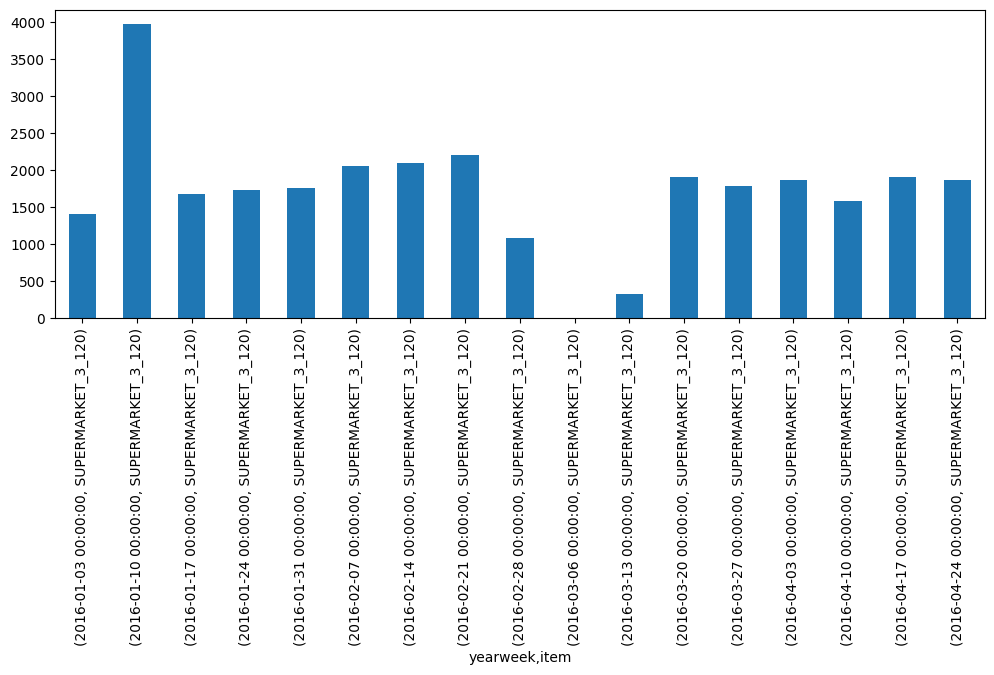

In [63]:
(df_forecast[(df_forecast['yearweek'].dt.year == 2016) & (df_forecast['item'] == "SUPERMARKET_3_120")]
               .groupby(["yearweek", "item"])["qty_sold"].sum()
               .sort_index()  # Ordena en orden cronológico
               .plot(kind="bar", figsize=(12, 4))
              )
#Miramos este producto como ejemplo, venta por semanas y evolución de precio

<Axes: xlabel='id'>

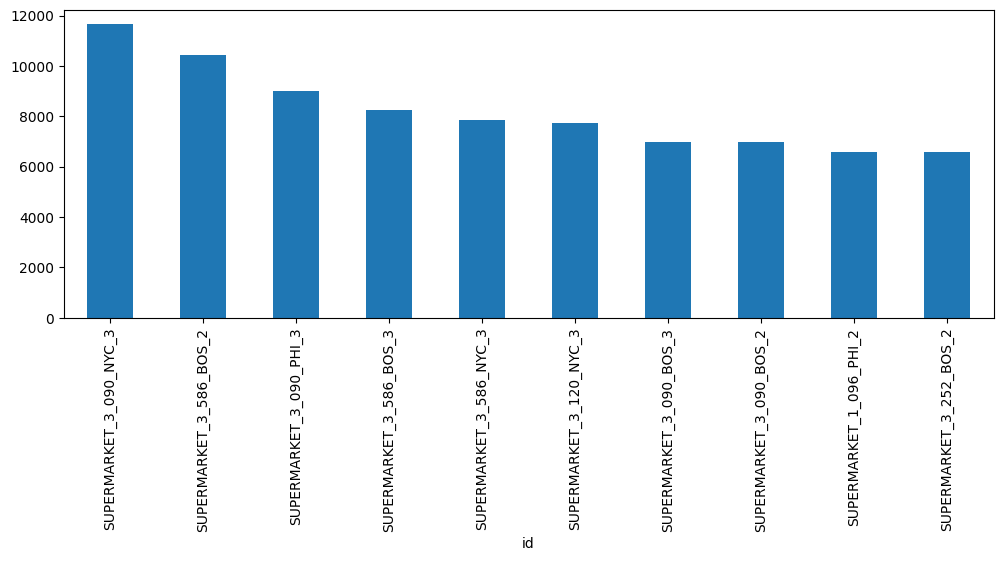

In [64]:
top_10_items = (df_forecast[df_forecast['yearweek'].dt.year == 2016]
                .groupby(["id"])["qty_sold"].sum()
                .sort_values(ascending=False)  # Ordena en orden descendente
                .head(10)  # Selecciona los top 10
               )
top_10_items.plot(kind="bar", figsize=(12, 4))

### --> 2. EDA: Top 3 Stores

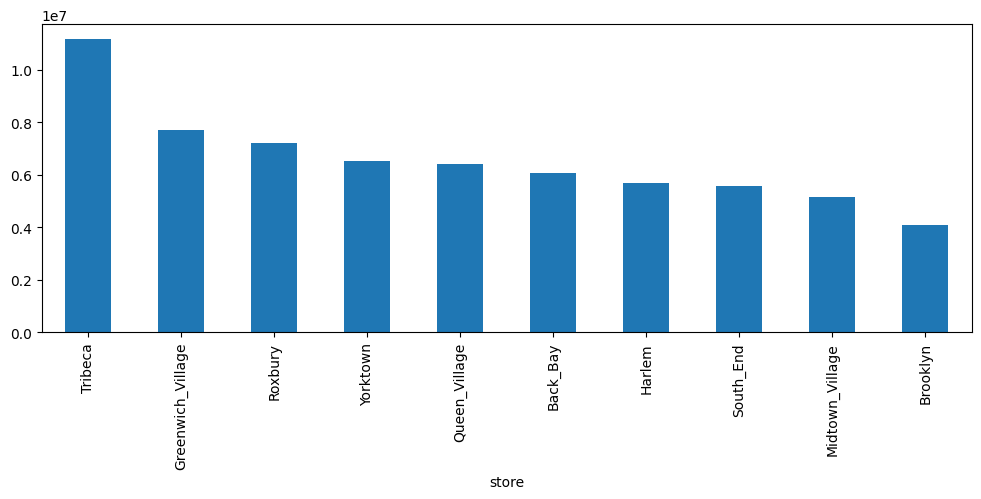

In [65]:
(
    df_forecast.
    groupby(["store"])
    ["qty_sold"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

In [66]:
df_forecast["store"].value_counts() #10 tiendas

store
South_End            835426
Roxbury              835426
Back_Bay             835426
Greenwich_Village    835426
Harlem               835426
Tribeca              835426
Brooklyn             835426
Midtown_Village      835426
Yorktown             835426
Queen_Village        835426
Name: count, dtype: int64

In [67]:
df_forecast["item"].value_counts() #3049 ítems

item
ACCESORIES_1_001       2740
SUPERMARKET_2_210      2740
SUPERMARKET_2_201      2740
SUPERMARKET_2_202      2740
SUPERMARKET_2_203      2740
                       ... 
HOME_&_GARDEN_1_464    2740
HOME_&_GARDEN_1_465    2740
HOME_&_GARDEN_1_466    2740
HOME_&_GARDEN_1_467    2740
SUPERMARKET_3_827      2740
Name: count, Length: 3049, dtype: int64


### --> 3. EDA: Top 3 Departments


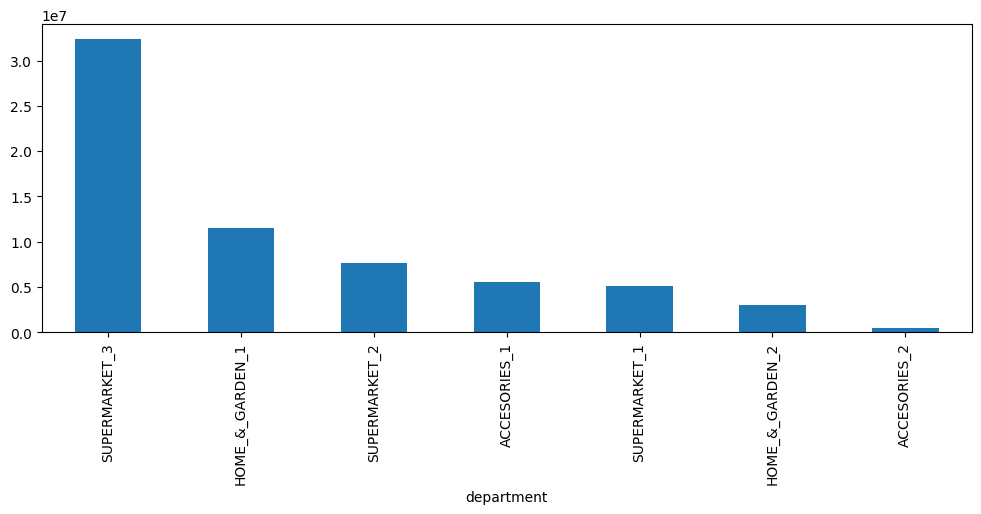

In [68]:
(
    df_forecast.
    groupby(["department"])
    ["qty_sold"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

# Build Time Series Features

In [69]:
df_forecast['qty_sold_log'] = df_forecast['qty_sold'].apply(np.log1p)

In [70]:
df_forecast['qty_sold_diff'] = df_forecast['qty_sold_log'].diff()

In [71]:
df_forecast.head()

,yearweek,id,item,category,department,store,store_code,region,qty_sold,sell_price,event,year,week,qty_sold_log,qty_sold_diff
0,2011-01-30,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,0,12.7414,0,2011,4,0.0,NaN
1,2011-02-06,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,0,12.7414,0,2011,5,0.0,0.0
2,2011-02-13,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,0,12.7414,SuperBowl,2011,6,0.0,0.0
3,2011-02-20,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,0,12.7414,0,2011,7,0.0,0.0
4,2011-02-27,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,0,12.7414,0,2011,8,0.0,0.0


In [72]:
def build_ts_vars(df, gb_list, target_column, agg_func, agg_func_name):
    
    assert "yearweek" in df.columns.tolist(), "yearweek must be in df columns"
    
    new_name = "_".join(gb_list + [target_column] + [agg_func_name])

    gb_df_ = (
        df_forecast
        .set_index("yearweek")
        .groupby(gb_list)
        .resample("W")[target_column]
        .apply(agg_func)
        .to_frame()
        .reset_index()
        .rename(
            columns = {
                target_column : new_name
            }
        )
    )
        
    gb_df_[f"{new_name}_lag1"] = gb_df_.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(1)
    )

    """gb_df_[f"{new_name}_lag2"] = gb_df_.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(2)
    )
    gb_df_[f"{new_name}_lag3"] = gb_df_.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(3)
    )
    
    print(f"Dropping columns that might cause target leakage {new_name}")
    gb_df_.drop(new_name, inplace = True, axis = 1)"""
    
    return gb_df_

In [73]:
GB_LIST = ["item"]
TARGET_COLUMN = "qty_sold_log"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "sum"

vars_ts_ = build_ts_vars(
    df = df_forecast,
    gb_list = GB_LIST,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME
    
)

vars_ts_.head(10)

,item,yearweek,item_qty_sold_log_sum,item_qty_sold_log_sum_lag1
0,ACCESORIES_1_001,2011-01-30,0.0,NaN
1,ACCESORIES_1_001,2011-02-06,0.0,0.0
2,ACCESORIES_1_001,2011-02-13,0.0,0.0
3,ACCESORIES_1_001,2011-02-20,0.0,0.0
4,ACCESORIES_1_001,2011-02-27,0.0,0.0
5,ACCESORIES_1_001,2011-03-06,0.0,0.0
6,ACCESORIES_1_001,2011-03-13,0.0,0.0
7,ACCESORIES_1_001,2011-03-20,0.0,0.0
8,ACCESORIES_1_001,2011-03-27,0.0,0.0
9,ACCESORIES_1_001,2011-04-03,0.0,0.0


### Join TS Features

In [74]:
print(df_forecast.shape)

df = pd.merge(df_forecast, vars_ts_, on = ["yearweek"] + GB_LIST, how = "left")

print(df.shape)

(8354260, 15)
(8354260, 17)


In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8354260 entries, 0 to 8354259
Data columns (total 17 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   yearweek                    datetime64[ns]
 1   id                          object        
 2   item                        object        
 3   category                    object        
 4   department                  object        
 5   store                       object        
 6   store_code                  object        
 7   region                      object        
 8   qty_sold                    int64         
 9   sell_price                  float64       
 10  event                       object        
 11  year                        int64         
 12  week                        int64         
 13  qty_sold_log                float64       
 14  qty_sold_diff               float64       
 15  item_qty_sold_log_sum       float64       
 16  item_qty_sold_log_

In [76]:
df.isnull().sum() #Revisamos Nulos, que solo tienen que estar en el registro 1 de nuestro dataset

yearweek                          0
id                                0
item                              0
category                          0
department                        0
store                             0
store_code                        0
region                            0
qty_sold                          0
sell_price                        0
event                             0
year                              0
week                              0
qty_sold_log                      0
qty_sold_diff                     1
item_qty_sold_log_sum             0
item_qty_sold_log_sum_lag1    30490
dtype: int64

In [77]:
"""df["item_qty_sold_sum_lag1"].fillna(-999, inplace = True)
df["item_qty_sold_sum_lag2"].fillna(-999, inplace = True)
df["item_qty_sold_sum_lag3"].fillna(-999, inplace = True)"""

'df["item_qty_sold_sum_lag1"].fillna(-999, inplace = True)\ndf["item_qty_sold_sum_lag2"].fillna(-999, inplace = True)\ndf["item_qty_sold_sum_lag3"].fillna(-999, inplace = True)'

In [78]:
df.head()

,yearweek,id,item,category,department,store,store_code,region,qty_sold,sell_price,event,year,week,qty_sold_log,qty_sold_diff,item_qty_sold_log_sum,item_qty_sold_log_sum_lag1
0,2011-01-30,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,0,12.7414,0,2011,4,0.0,NaN,0.0,NaN
1,2011-02-06,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,0,12.7414,0,2011,5,0.0,0.0,0.0,0.0
2,2011-02-13,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,0,12.7414,SuperBowl,2011,6,0.0,0.0,0.0,0.0
3,2011-02-20,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,0,12.7414,0,2011,7,0.0,0.0,0.0,0.0
4,2011-02-27,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,0,12.7414,0,2011,8,0.0,0.0,0.0,0.0


Para hacer el subsample, teniendo en cuenta los últimos 2 años y medio de los productos que hacen el 60% de la venta

In [79]:
"""#Definimos fecha máx. calculamos ultimos 2 años y medio recientes y aplicamos fórmula cumsum
max_yearweek = df['yearweek'].max()
df_2years = max_yearweek - pd.DateOffset(years=2, months=6)
df_2MAT= df[df['yearweek']>= df_2years]
df_sample= df_2MAT.copy()"""

"#Definimos fecha máx. calculamos ultimos 2 años y medio recientes y aplicamos fórmula cumsum\nmax_yearweek = df['yearweek'].max()\ndf_2years = max_yearweek - pd.DateOffset(years=2, months=6)\ndf_2MAT= df[df['yearweek']>= df_2years]\ndf_sample= df_2MAT.copy()"

In [80]:
"""# Aplica la lógica existente para obtener los productos que representan el 60% de las ventas
df_sample_id= df_2MAT.groupby("id")["qty_sold"].sum().sort_values(ascending=False).cumsum().div(df_2MAT["qty_sold"].sum()).loc[lambda x: x <= 0.6].index"""

'# Aplica la lógica existente para obtener los productos que representan el 60% de las ventas\ndf_sample_id= df_2MAT.groupby("id")["qty_sold"].sum().sort_values(ascending=False).cumsum().div(df_2MAT["qty_sold"].sum()).loc[lambda x: x <= 0.6].index'

In [81]:
"""df_sample_top60 = df[df["id"].isin(df_sample_id)]"""

'df_sample_top60 = df[df["id"].isin(df_sample_id)]'

In [82]:
"""df_sample.head()"""

'df_sample.head()'

In [83]:
"""MIN_DATE = df_sample["yearweek"].min()
MAX_DATE = df_sample["yearweek"].max()"""

'MIN_DATE = df_sample["yearweek"].min()\nMAX_DATE = df_sample["yearweek"].max()'

In [84]:
"""print(f"Min date is {MIN_DATE}\nMax date is {MAX_DATE}") """

'print(f"Min date is {MIN_DATE}\nMax date is {MAX_DATE}") '

In [85]:
"""df_sample.info()"""

'df_sample.info()'

In [86]:
"""df_sample.shape"""

'df_sample.shape'

In [87]:
df_encoded = df.copy()

In [88]:
df_encoded["item"].value_counts()

item
ACCESORIES_1_001       2740
SUPERMARKET_2_210      2740
SUPERMARKET_2_201      2740
SUPERMARKET_2_202      2740
SUPERMARKET_2_203      2740
                       ... 
HOME_&_GARDEN_1_464    2740
HOME_&_GARDEN_1_465    2740
HOME_&_GARDEN_1_466    2740
HOME_&_GARDEN_1_467    2740
SUPERMARKET_3_827      2740
Name: count, Length: 3049, dtype: int64

# Encoding categoricos

In [89]:
# Print categoricos
cat_cols = list(df_encoded.select_dtypes(include=['object','category']).columns)
if 'id' in cat_cols:
    cat_cols.remove('id')
cat_cols

['item', 'category', 'department', 'store', 'store_code', 'region', 'event']

Creamos Diccionarios con bucles por si existen nuevos registros y para hacer más eficiente

In [90]:
# Creamos un diccionario vacío para almacenar las codificaciones
encoding_dict = {}

# Iteramos sobre cada columna categórica
for col in cat_cols:
    # Creamos un diccionario vacío para esta columna
    encoding_dict[col] = {}
    
    for i, value in enumerate(df_encoded[col].unique()):
        encoding_dict[col][value] = i

# Imprimimos los diccionarios resultantes
for col, codificacion in encoding_dict.items():
    print(f"Codificación para la columna '{col}': {codificacion}")


Codificación para la columna 'item': {'ACCESORIES_1_001': 0, 'ACCESORIES_1_002': 1, 'ACCESORIES_1_003': 2, 'ACCESORIES_1_004': 3, 'ACCESORIES_1_005': 4, 'ACCESORIES_1_006': 5, 'ACCESORIES_1_007': 6, 'ACCESORIES_1_008': 7, 'ACCESORIES_1_009': 8, 'ACCESORIES_1_010': 9, 'ACCESORIES_1_011': 10, 'ACCESORIES_1_012': 11, 'ACCESORIES_1_013': 12, 'ACCESORIES_1_014': 13, 'ACCESORIES_1_015': 14, 'ACCESORIES_1_016': 15, 'ACCESORIES_1_017': 16, 'ACCESORIES_1_018': 17, 'ACCESORIES_1_019': 18, 'ACCESORIES_1_020': 19, 'ACCESORIES_1_021': 20, 'ACCESORIES_1_022': 21, 'ACCESORIES_1_023': 22, 'ACCESORIES_1_024': 23, 'ACCESORIES_1_025': 24, 'ACCESORIES_1_026': 25, 'ACCESORIES_1_027': 26, 'ACCESORIES_1_028': 27, 'ACCESORIES_1_029': 28, 'ACCESORIES_1_030': 29, 'ACCESORIES_1_031': 30, 'ACCESORIES_1_032': 31, 'ACCESORIES_1_033': 32, 'ACCESORIES_1_034': 33, 'ACCESORIES_1_035': 34, 'ACCESORIES_1_036': 35, 'ACCESORIES_1_037': 36, 'ACCESORIES_1_038': 37, 'ACCESORIES_1_039': 38, 'ACCESORIES_1_040': 39, 'ACCESORIES_

In [91]:
# Aplicamos map para imputar categóricos
def encode_column_with_dict(column, encoding_dict):
    return column.map(encoding_dict)

for col in cat_cols:
    df_encoded[col + '_encoded'] = encode_column_with_dict(df_encoded[col], encoding_dict[col])

# Mostrar el DataFrame resultante
print(df_encoded)


          yearweek                       id               item     category  \
0       2011-01-30   ACCESORIES_1_001_BOS_1   ACCESORIES_1_001   ACCESORIES   
1       2011-02-06   ACCESORIES_1_001_BOS_1   ACCESORIES_1_001   ACCESORIES   
2       2011-02-13   ACCESORIES_1_001_BOS_1   ACCESORIES_1_001   ACCESORIES   
3       2011-02-20   ACCESORIES_1_001_BOS_1   ACCESORIES_1_001   ACCESORIES   
4       2011-02-27   ACCESORIES_1_001_BOS_1   ACCESORIES_1_001   ACCESORIES   
...            ...                      ...                ...          ...   
8354255 2016-03-27  SUPERMARKET_3_827_PHI_3  SUPERMARKET_3_827  SUPERMARKET   
8354256 2016-04-03  SUPERMARKET_3_827_PHI_3  SUPERMARKET_3_827  SUPERMARKET   
8354257 2016-04-10  SUPERMARKET_3_827_PHI_3  SUPERMARKET_3_827  SUPERMARKET   
8354258 2016-04-17  SUPERMARKET_3_827_PHI_3  SUPERMARKET_3_827  SUPERMARKET   
8354259 2016-04-24  SUPERMARKET_3_827_PHI_3  SUPERMARKET_3_827  SUPERMARKET   

            department          store store_code   

In [92]:
#Columnas a eliminar, que ya tenemos encodeadas
df_encoded.drop(columns=['category', "item", "department", "store", "store_code", "region", "event"], inplace=True)

In [93]:
df_encoded.head()

,yearweek,id,qty_sold,sell_price,year,week,qty_sold_log,qty_sold_diff,item_qty_sold_log_sum,item_qty_sold_log_sum_lag1,item_encoded,category_encoded,department_encoded,store_encoded,store_code_encoded,region_encoded,event_encoded
0,2011-01-30,ACCESORIES_1_001_BOS_1,0,12.7414,2011,4,0.0,NaN,0.0,NaN,0,0,0,0,0,0,0
1,2011-02-06,ACCESORIES_1_001_BOS_1,0,12.7414,2011,5,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
2,2011-02-13,ACCESORIES_1_001_BOS_1,0,12.7414,2011,6,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1
3,2011-02-20,ACCESORIES_1_001_BOS_1,0,12.7414,2011,7,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
4,2011-02-27,ACCESORIES_1_001_BOS_1,0,12.7414,2011,8,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0


In [94]:
"""# Inicializamos el codificador de etiquetas
label_encoder = LabelEncoder()

# Iteramos sobre todas las columnas categóricas y aplicamos el Label Encoding
for col in cat_cols:
    df_encoded[col + '_encoded'] = label_encoder.fit_transform(df_encoded[col])

# Eliminamos las columnas categóricas originales si es necesario
df_encoded.drop(columns=cat_cols, inplace=True)

# Imprimimos el DataFrame resultante
print(df_encoded)"""

"# Inicializamos el codificador de etiquetas\nlabel_encoder = LabelEncoder()\n\n# Iteramos sobre todas las columnas categóricas y aplicamos el Label Encoding\nfor col in cat_cols:\n    df_encoded[col + '_encoded'] = label_encoder.fit_transform(df_encoded[col])\n\n# Eliminamos las columnas categóricas originales si es necesario\ndf_encoded.drop(columns=cat_cols, inplace=True)\n\n# Imprimimos el DataFrame resultante\nprint(df_encoded)"

In [95]:
"""df_encoded = pd.get_dummies(df_encoded, columns=cat_cols)"""

'df_encoded = pd.get_dummies(df_encoded, columns=cat_cols)'

In [96]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8354260 entries, 0 to 8354259
Data columns (total 17 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   yearweek                    datetime64[ns]
 1   id                          object        
 2   qty_sold                    int64         
 3   sell_price                  float64       
 4   year                        int64         
 5   week                        int64         
 6   qty_sold_log                float64       
 7   qty_sold_diff               float64       
 8   item_qty_sold_log_sum       float64       
 9   item_qty_sold_log_sum_lag1  float64       
 10  item_encoded                int64         
 11  category_encoded            int64         
 12  department_encoded          int64         
 13  store_encoded               int64         
 14  store_code_encoded          int64         
 15  region_encoded              int64         
 16  event_encoded     

In [97]:
df_encoded.shape

(8354260, 17)

# Eliminamos Alta correlación

# Eliminamos Baja Varianza

# Train Test Split

In [98]:
df2=df_encoded.copy()

In [99]:
#df2.fillna(0, inplace=True)

In [100]:
df2.head()

,yearweek,id,qty_sold,sell_price,year,week,qty_sold_log,qty_sold_diff,item_qty_sold_log_sum,item_qty_sold_log_sum_lag1,item_encoded,category_encoded,department_encoded,store_encoded,store_code_encoded,region_encoded,event_encoded
0,2011-01-30,ACCESORIES_1_001_BOS_1,0,12.7414,2011,4,0.0,NaN,0.0,NaN,0,0,0,0,0,0,0
1,2011-02-06,ACCESORIES_1_001_BOS_1,0,12.7414,2011,5,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
2,2011-02-13,ACCESORIES_1_001_BOS_1,0,12.7414,2011,6,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1
3,2011-02-20,ACCESORIES_1_001_BOS_1,0,12.7414,2011,7,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
4,2011-02-27,ACCESORIES_1_001_BOS_1,0,12.7414,2011,8,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0


In [101]:
df2.shape

(8354260, 17)

Eliminamos variables

In [102]:
df2.columns.tolist()

['yearweek',
 'id',
 'qty_sold',
 'sell_price',
 'year',
 'week',
 'qty_sold_log',
 'qty_sold_diff',
 'item_qty_sold_log_sum',
 'item_qty_sold_log_sum_lag1',
 'item_encoded',
 'category_encoded',
 'department_encoded',
 'store_encoded',
 'store_code_encoded',
 'region_encoded',
 'event_encoded']

In [103]:
COLUMNS_TO_DROP = [ 

]
df2.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)

In [104]:
df2.isnull().sum()

yearweek                          0
id                                0
qty_sold                          0
sell_price                        0
year                              0
week                              0
qty_sold_log                      0
qty_sold_diff                     1
item_qty_sold_log_sum             0
item_qty_sold_log_sum_lag1    30490
item_encoded                      0
category_encoded                  0
department_encoded                0
store_encoded                     0
store_code_encoded                0
region_encoded                    0
event_encoded                     0
dtype: int64

In [105]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8354260 entries, 0 to 8354259
Data columns (total 17 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   yearweek                    datetime64[ns]
 1   id                          object        
 2   qty_sold                    int64         
 3   sell_price                  float64       
 4   year                        int64         
 5   week                        int64         
 6   qty_sold_log                float64       
 7   qty_sold_diff               float64       
 8   item_qty_sold_log_sum       float64       
 9   item_qty_sold_log_sum_lag1  float64       
 10  item_encoded                int64         
 11  category_encoded            int64         
 12  department_encoded          int64         
 13  store_encoded               int64         
 14  store_code_encoded          int64         
 15  region_encoded              int64         
 16  event_encoded     

In [106]:
df2.shape

(8354260, 17)

In [107]:
#Convertimos "id" en Index
df2.set_index('id', inplace=True)

In [108]:
train_index = sorted(list(df2["yearweek"].unique()))[:-8]

valida_index = [sorted(list(df2["yearweek"].unique()))[-8]]

test_index = [sorted(list(df2["yearweek"].unique()))[-4]]

In [109]:
valida_index

[Timestamp('2016-03-06 00:00:00')]

In [110]:
print(f"Our train index is {train_index[:2]} - ... - {train_index[-2:]}\n")
print(f"Our validation index is {valida_index}\n")
print(f"Our test/prediction index is {test_index}\n")

Our train index is [Timestamp('2011-01-30 00:00:00'), Timestamp('2011-02-06 00:00:00')] - ... - [Timestamp('2016-02-21 00:00:00'), Timestamp('2016-02-28 00:00:00')]

Our validation index is [Timestamp('2016-03-06 00:00:00')]

Our test/prediction index is [Timestamp('2016-04-03 00:00:00')]



In [111]:
X_train = df2[df2["yearweek"].isin(train_index)].drop(['qty_sold', "yearweek"], axis=1)
Y_train = df2[df2["yearweek"].isin(train_index)]['qty_sold']

X_valida = df2[df2["yearweek"].isin(valida_index)].drop(['qty_sold', "yearweek"], axis=1)
Y_valida = df2[df2["yearweek"].isin(valida_index)]['qty_sold']

X_test = df2[df2["yearweek"].isin(test_index)].drop(['qty_sold', "yearweek"], axis = 1)
Y_test = df2[df2["yearweek"].isin(test_index)]['qty_sold']

In [112]:
X_train.head(20) #Comprobamos que esté en orden las fechas

,sell_price,year,week,qty_sold_log,qty_sold_diff,item_qty_sold_log_sum,item_qty_sold_log_sum_lag1,item_encoded,category_encoded,department_encoded,store_encoded,store_code_encoded,region_encoded,event_encoded
id,,,,,,,,,,,,,,
ACCESORIES_1_001_BOS_1,12.7414,2011,4,0.0,NaN,0.0,NaN,0,0,0,0,0,0,0
ACCESORIES_1_001_BOS_1,12.7414,2011,5,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
ACCESORIES_1_001_BOS_1,12.7414,2011,6,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1
ACCESORIES_1_001_BOS_1,12.7414,2011,7,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
ACCESORIES_1_001_BOS_1,12.7414,2011,8,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
ACCESORIES_1_001_BOS_1,12.7414,2011,9,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
ACCESORIES_1_001_BOS_1,12.7414,2011,10,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
ACCESORIES_1_001_BOS_1,12.7414,2011,11,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
ACCESORIES_1_001_BOS_1,12.7414,2011,12,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0


In [113]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8110340 entries, ACCESORIES_1_001_BOS_1 to SUPERMARKET_3_827_PHI_3
Data columns (total 14 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   sell_price                  float64
 1   year                        int64  
 2   week                        int64  
 3   qty_sold_log                float64
 4   qty_sold_diff               float64
 5   item_qty_sold_log_sum       float64
 6   item_qty_sold_log_sum_lag1  float64
 7   item_encoded                int64  
 8   category_encoded            int64  
 9   department_encoded          int64  
 10  store_encoded               int64  
 11  store_code_encoded          int64  
 12  region_encoded              int64  
 13  event_encoded               int64  
dtypes: float64(5), int64(9)
memory usage: 928.2+ MB


In [114]:
Y_train.info()

<class 'pandas.core.series.Series'>
Index: 8110340 entries, ACCESORIES_1_001_BOS_1 to SUPERMARKET_3_827_PHI_3
Series name: qty_sold
Non-Null Count    Dtype
--------------    -----
8110340 non-null  int64
dtypes: int64(1)
memory usage: 123.8+ MB


In [115]:
X_valida.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30490 entries, ACCESORIES_1_001_BOS_1 to SUPERMARKET_3_827_PHI_3
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   sell_price                  30490 non-null  float64
 1   year                        30490 non-null  int64  
 2   week                        30490 non-null  int64  
 3   qty_sold_log                30490 non-null  float64
 4   qty_sold_diff               30490 non-null  float64
 5   item_qty_sold_log_sum       30490 non-null  float64
 6   item_qty_sold_log_sum_lag1  30490 non-null  float64
 7   item_encoded                30490 non-null  int64  
 8   category_encoded            30490 non-null  int64  
 9   department_encoded          30490 non-null  int64  
 10  store_encoded               30490 non-null  int64  
 11  store_code_encoded          30490 non-null  int64  
 12  region_encoded              30490 non-null  int64  
 1

# Model Train

### Torneo de Modelos

In [116]:
def RMSE(model,X,y):
  model.fit(X,y)
  return round(np.sqrt(np.mean((y-model.predict(X))**2)),2)

def RMSE_cross_validation(model,X,y):
  Kfold_rmse = cross_val_score(model, X, y, cv=4, scoring='neg_root_mean_squared_error')
  return round(-Kfold_rmse.mean(),4)

In [117]:
# Inicializa resultados
label_ = []
rmse_train_ = []
rmse_valida_ = []

# Funcion que devuelve un dataframe con resultados de RMSE Cross Validation
def evaluate_regression(model, X, y, label=None):
  if label is None:
    label = str(model)

  rmse_train = RMSE(model,X,y)
  rmse_valida = RMSE_cross_validation(model,X,y)

  label_.append(label)
  rmse_train_.append(rmse_train)
  rmse_valida_.append(rmse_valida)

  return pd.DataFrame({'Model': label_,
                      'RMSE Train': rmse_train_,
                      'RMSE Cross-Validation': rmse_valida_
                      }).sort_values('RMSE Cross-Validation')

In [118]:
"""evaluate_regression(model = LinearRegression(), #No funciona si el df tiene NA
                    X=X_train, y=Y_train)"""

'evaluate_regression(model = LinearRegression(), #No funciona si el df tiene NA\n                    X=X_train, y=Y_train)'

In [119]:
"""evaluate_regression(model = Lasso(alpha=1),#No funciona si el df tiene NA
                    X=X_train, y=Y_train)"""

'evaluate_regression(model = Lasso(alpha=1),#No funciona si el df tiene NA\n                    X=X_train, y=Y_train)'

In [120]:
"""evaluate_regression(model = Ridge(alpha=10), #No funciona si el df tiene NA
                    X=X_train, y=Y_train)"""

'evaluate_regression(model = Ridge(alpha=10), #No funciona si el df tiene NA\n                    X=X_train, y=Y_train)'

In [121]:
"""evaluate_regression(model = ElasticNet(l1_ratio=0.5), #No funciona si el df tiene NA
                    X=X_train, y=Y_train)"""

'evaluate_regression(model = ElasticNet(l1_ratio=0.5), #No funciona si el df tiene NA\n                    X=X_train, y=Y_train)'

In [123]:
evaluate_regression(model = XGBRegressor(objective ='reg:squarederror'),
                    X=X_train, y=Y_train)

,Model,RMSE Train,RMSE Cross-Validation
0,"XGBRegressor(base_score=None, booster=None, ca...",4.13,8.6466


Implementamos Modelo ARIMA para ver si nos da mejor!! No se puede implementar por los tiempos de ejecución 5 TS toma alrededor de 50 minutos

In [ ]:
#Convertimos Yearweek a Index, ya que lo necesitamos para usar ARIMA y nos aseguramos que siga el orden 
"""df.reset_index(inplace=True)
df.set_index("yearweek", inplace=True)
df.sort_index(inplace=True)"""


'df.reset_index(inplace=True)\ndf.set_index("yearweek", inplace=True)\ndf.sort_index(inplace=True)'

In [ ]:
# Supongamos que df es tu DataFrame con muchas series temporales
# Seleccionar 5 series temporales al azar
"""sample_df = df.sample(n=5, axis=1)"""


'sample_df = df.sample(n=5, axis=1)'

In [ ]:
"""sample_df.head()""" #Miramos los "id" y seleccionamos uno para ver el resultado de ARIMA

'sample_df.head()'

In [ ]:
"""results = {}
for col in sample_df.columns:
    try:
        model = ARIMA(sample_df[col], order=(1,1,1))
        result = model.fit()
        results[col] = result
    except:
        results[col] = "Error al ajustar el modelo"  # Manejar errores si la serie temporal no es adecuada para ARIMA

# Ahora puedes acceder a los resultados de cada serie temporal en el diccionario 'results'
# Por ejemplo, para obtener el resumen del modelo ajustado para la primera serie temporal:
print(results['ACCESORIES_1_137_PHI_2'].summary())"""

'results = {}\nfor col in sample_df.columns:\n    try:\n        model = ARIMA(sample_df[col], order=(1,1,1))\n        result = model.fit()\n        results[col] = result\n    except:\n        results[col] = "Error al ajustar el modelo"  # Manejar errores si la serie temporal no es adecuada para ARIMA\n\n# Ahora puedes acceder a los resultados de cada serie temporal en el diccionario \'results\'\n# Por ejemplo, para obtener el resumen del modelo ajustado para la primera serie temporal:\nprint(results[\'ACCESORIES_1_137_PHI_2\'].summary())'

In [124]:
model = xgb.XGBRegressor(eval_metric = "rmse", seed = 175)

model.fit(X_train, Y_train, eval_set = [(X_train, Y_train), (X_valida, Y_valida)], verbose = True)

[0]	validation_0-rmse:17.24845	validation_1-rmse:15.34005
[1]	validation_0-rmse:12.94255	validation_1-rmse:10.89690
[2]	validation_0-rmse:10.17232	validation_1-rmse:7.88394
[3]	validation_0-rmse:8.34408	validation_1-rmse:5.88812
[4]	validation_0-rmse:7.32751	validation_1-rmse:4.76073
[5]	validation_0-rmse:6.75504	validation_1-rmse:4.15024
[6]	validation_0-rmse:6.41667	validation_1-rmse:3.80132
[7]	validation_0-rmse:6.22526	validation_1-rmse:3.68390
[8]	validation_0-rmse:6.11257	validation_1-rmse:3.64313
[9]	validation_0-rmse:6.01565	validation_1-rmse:3.59854
[10]	validation_0-rmse:5.95287	validation_1-rmse:3.54933
[11]	validation_0-rmse:5.91466	validation_1-rmse:3.54859
[12]	validation_0-rmse:5.87366	validation_1-rmse:3.57976
[13]	validation_0-rmse:5.83061	validation_1-rmse:3.54156
[14]	validation_0-rmse:5.81251	validation_1-rmse:3.56486
[15]	validation_0-rmse:5.78750	validation_1-rmse:3.54265
[16]	validation_0-rmse:5.76037	validation_1-rmse:3.55320
[17]	validation_0-rmse:5.74892	valid

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

#  Model Evaluation

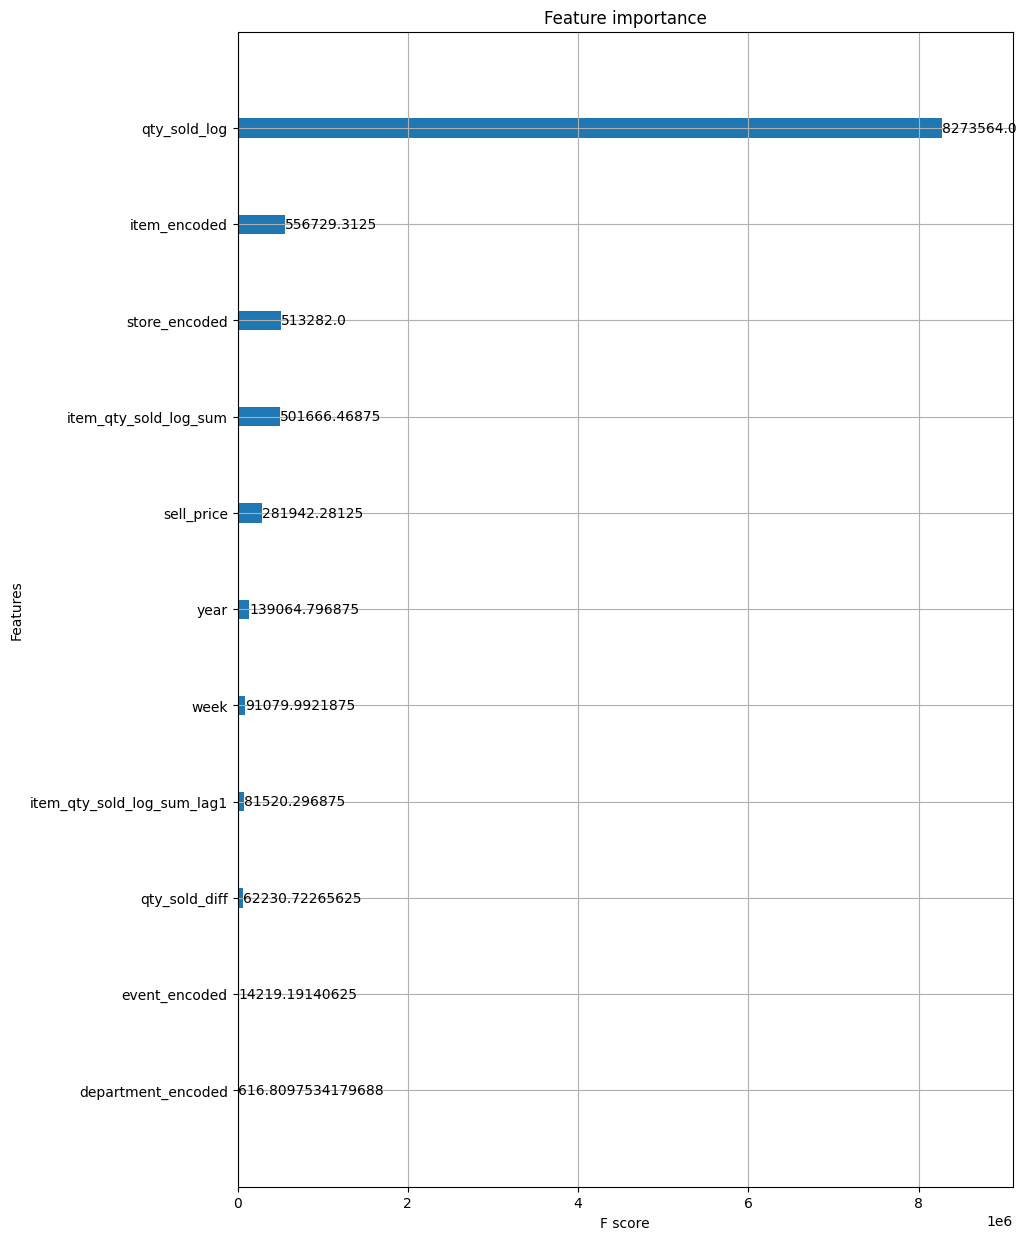

In [125]:
fig, ax = plt.subplots(figsize = (10, 15))
xgb.plot_importance(model, importance_type = "gain", ax = ax);

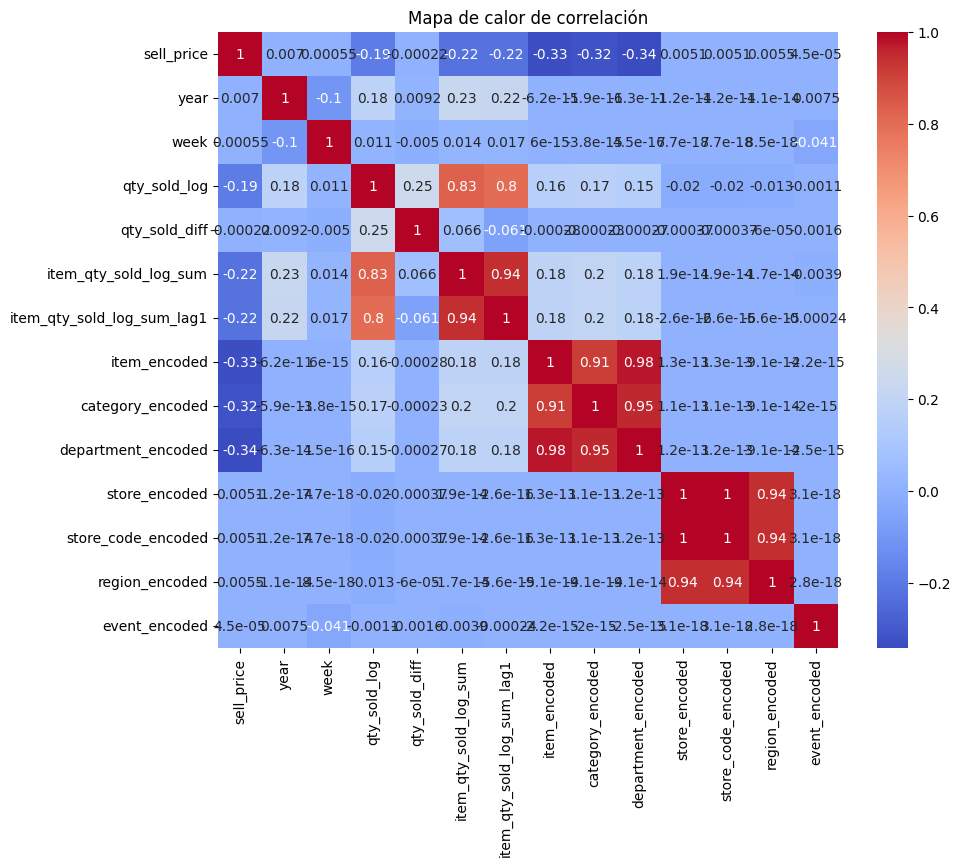

In [126]:
correlation_matrix = X_train.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Mapa de calor de correlación")
plt.show()

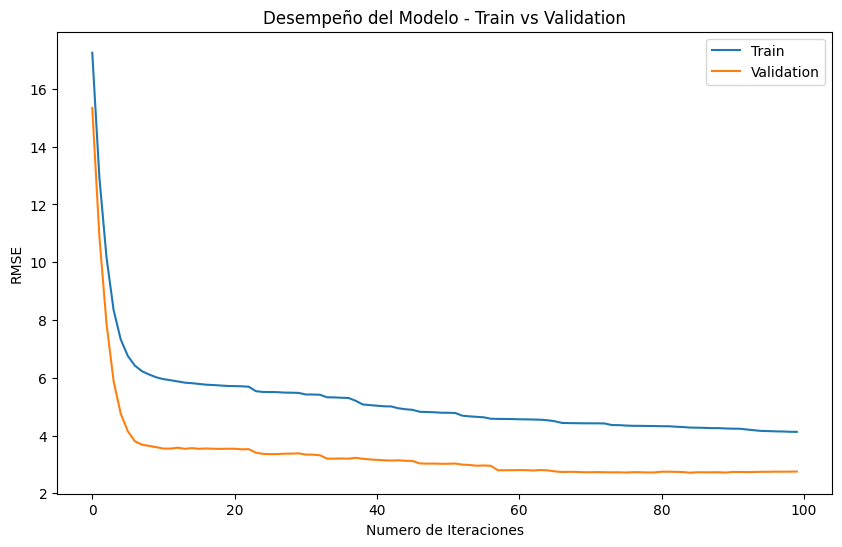

In [127]:
# Obtener métricas
results = model.evals_result()
# Gráfica de métricas
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
# Métricas de entrenamiento
plt.plot(x_axis, results['validation_0']['rmse'], label='Train')
# Métricas de validação
plt.plot(x_axis, results['validation_1']['rmse'], label='Validation')
plt.legend()
plt.xlabel('Numero de Iteraciones')
plt.ylabel('RMSE')
plt.title('Desempeño del Modelo - Train vs Validation')
plt.show()

# Hiperparametrizacion

In [128]:
parameters_hp = {
    'loss': ['squared_error', 'huber'],  # Reducir a solo dos opciones
    'penalty': [None],  # Eliminar l1 y l2
    'alpha': [0.0001, 0.1],  # Reducir a dos opciones
    'l1_ratio': [0.15],  # Quedarse con un solo valor
    'max_iter': [1000, 5000],  # Reducir a dos opciones
    'learning_rate': ['invscaling', 'optimal'],  # Reducir a dos opciones
    'eta0': [0.01],  # Quedarse con un solo valor
    'early_stopping': [True],  # Quedarse con un solo valor
    'n_iter_no_change': [5]  # Quedarse con un solo valor
}

In [129]:
search_hp = RandomizedSearchCV(estimator=SGDRegressor(),
                               param_distributions = parameters_hp,
                               scoring='neg_root_mean_squared_error',     # metrica a optimizar: RMSE
                               cv = 4,                                    # numero de folds para cross-validation
                               n_iter = 50,                               # numero de iteraciones, cada una testeara una configuracion distinta
                               n_jobs=-1,
                               verbose=True)

In [130]:
X_train.head()

,sell_price,year,week,qty_sold_log,qty_sold_diff,item_qty_sold_log_sum,item_qty_sold_log_sum_lag1,item_encoded,category_encoded,department_encoded,store_encoded,store_code_encoded,region_encoded,event_encoded
id,,,,,,,,,,,,,,
ACCESORIES_1_001_BOS_1,12.7414,2011,4,0.0,NaN,0.0,NaN,0,0,0,0,0,0,0
ACCESORIES_1_001_BOS_1,12.7414,2011,5,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
ACCESORIES_1_001_BOS_1,12.7414,2011,6,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1
ACCESORIES_1_001_BOS_1,12.7414,2011,7,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
ACCESORIES_1_001_BOS_1,12.7414,2011,8,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0


In [131]:
"""search_hp.fit(X_train, Y_train)#No funciona si el df tiene NA"""

'search_hp.fit(X_train, Y_train)#No funciona si el df tiene NA'

In [132]:
"""print("---- Results from Random Search -----" )
print("\n The best estimator across ALL searched params:", search_hp.best_estimator_)
print("\n The best RMSE:", -search_hp.best_score_)
print("\n The best parameters across ALL searched params:\n", search_hp.best_params_)"""

'print("---- Results from Random Search -----" )\nprint("\n The best estimator across ALL searched params:", search_hp.best_estimator_)\nprint("\n The best RMSE:", -search_hp.best_score_)\nprint("\n The best parameters across ALL searched params:\n", search_hp.best_params_)'

# Prediction

In [133]:
if "qty_sold" in X_test.columns:
    X_test.drop("qty_sold", axis = 1, inplace = True)
    
Y_test_predict = model.predict(X_test)
X_test["qty_sold"] = Y_test_predict

In [134]:
X_test.reset_index(inplace = True)

In [135]:
Y_train_predict = model.predict(X_train)
Y_valida_predict = model.predict(X_valida)

rmse_train = np.sqrt(
    mean_squared_error(
        y_true = Y_train,
        y_pred = Y_train_predict
    )
)

rmse_valida = np.sqrt(
    mean_squared_error(
        y_true = Y_valida,
        y_pred = Y_valida_predict
    )
)

rmse_train= str(round(rmse_train, 3)).replace(".", "_")
rmse_valida = str(round(rmse_valida, 3)).replace(".", "_")

In [136]:
print(f"Train RMSE: {rmse_train}")
print(f"Validation RMSE: {rmse_valida}")

Train RMSE: 4_128
Validation RMSE: 2_756


# Ensayos

In [137]:
"""Mejor resultado hasta ahora

Train RMSE: 4_128
Validation RMSE: 2_756

['yearweek','id','qty_sold','sell_price','year','week','qty_sold_log','qty_sold_diff','item_qty_sold_log_sum','item_qty_sold_log_sum_lag1',
 'item_encoded','category_encoded','department_encoded','store_encoded','store_code_encoded','region_encoded','event_encoded']


--------------------------------------------------------------------------------------------------------------------------
Train RMSE: 4_064
Validation RMSE: 2_862

Incluye columnas:

['yearweek','id','qty_sold','sell_price','year','week','qty_sold_log','qty_sold_diff','item_qty_sold_sum','item_qty_sold_sum_lag1','item_encoded',
 'category_encoded','department_encoded','store_encoded','store_code_encoded','region_encoded','event_encoded']
---------------------------------------------------------------------------------------------------------------------
Eliminando altas correlaciones y variales autoexplicativas!!
Train RMSE: 10_658
Validation RMSE: 10_493

Incluye Columnas:

['yearweek','id','qty_sold','sell_price','year','week','qty_sold_diff','item_qty_sold_log_sum_lag1','item_encoded',
 ,'store_encoded','region_encoded','event_encoded']
---------------------------------------------------------------------------------------------------------------------
Train RMSE: 10_112
Validation RMSE: 10_28

Incluye todas las variables:
['yearweek','id','qty_sold','sell_price','year','week','item_qty_sold_sum','item_qty_sold_sum_lag1','item_encoded','category_encoded',
'department_encoded','store_encoded',
'store_code_encoded','region_encoded','event_encoded']
-----------------------------------------------------------------------------------------------------------------------
Eliminando Variables altamente correlacionadas
Train RMSE: 11_442
Validation RMSE: 11_505

Variables eliminadas:
'item_qty_sold_sum', 'store_code_encoded','category_encoded',
 'department_encoded',

-----------------------------------------------------------------------------------------------------------------------
Eliminando Variables altamente correlacionadas region, department. Rellenando con Fill NA=0 los NA de lag_1
Train RMSE: 13_512
Validation RMSE: 12_718"""

"\nMejor resultado hasta ahora\nTrain RMSE: 4_064\nValidation RMSE: 2_862\n\nIncluye columnas:\n\n['yearweek','id','qty_sold','sell_price','year','week','qty_sold_log','qty_sold_diff','item_qty_sold_sum','item_qty_sold_sum_lag1','item_encoded',\n 'category_encoded','department_encoded','store_encoded','store_code_encoded','region_encoded','event_encoded']\n---------------------------------------------------------------------------------------------------------------------\nEliminando altas correlaciones y variales autoexplicativas!!\nTrain RMSE: 10_658\nValidation RMSE: 10_493\n\nIncluye Columnas:\n\n['yearweek','id','qty_sold','sell_price','year','week','qty_sold_diff','item_qty_sold_log_sum_lag1','item_encoded',\n ,'store_encoded','region_encoded','event_encoded']\n---------------------------------------------------------------------------------------------------------------------\nTrain RMSE: 10_112\nValidation RMSE: 10_28\n\nIncluye todas las variables:\n['yearweek','id','qty_sold'